In [1]:
from chainer import links as L
import chainer.functions as F
import chainer
from chainer import Chain, Link
from chainer import Parameter
from chainer.links import VGG16Layers
from chainer.links.model.vision.vgg import prepare as VGGprepare
from chainer import Variable, optimizers
import numpy as np
import PIL.Image
from io import BytesIO

mean = [103.939, 116.779, 123.68]   # BGR
#  modelVGG = VGG16Layers()

from IPython.display import clear_output, Image, display
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# 基本入出力関数

# 配列の表示
def showarray(a, fmt='jpeg'):  # numpy 配列としての画像を表示
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# blob データを PIL 画像に変換
def blob2img(blob, mean=mean):
    blob = (np.dstack(blob)+ mean)[:,:,::-1]   # BGR 2 RGB
    return PIL.Image.fromarray(np.uint8(blob))

# blob データを画像として保存
def save_image(blobimg, it):
    def clip(a):
        return 0 if a<0 else (255 if a>255 else a)
    blobimg = np.vectorize(clip)(blobimg)
    image = blob2img(blobimg)
    image.save("frames/im_%05d.png"%it)
    return image

# チャネル間の相関行列
def ch_corr_matrix(ld):
    # 0次元目はバッチ数
    ch = ld.shape[1] # チャネル数
    size = ld[0][0].size  # チャネルあたりのデータ数
    cmatrix = F.reshape(ld, (ch,size)) # チャネルごとに１次元化した ch x size の配列を作る
    matrix = F.matmul(cmatrix, cmatrix,transb=True) / np.float32(size) # 相関行列
    return matrix

In [3]:
# layers_for_orig = ["conv4_1", "conv4_2", "conv4_3", "pool4"]
# layers_for_style =["conv1_1", "conv1_2", "pool1", "conv2_1", "conv2_2", "pool2", "conv3_1", "conv3_2", "conv3_3v3","pool3"]

lr = np.float32(400.0) # 学習係数
rr = np.float32(0.005) # 元画像/スタイル画像 比率
width = 224
CROPSIZE = (3,224,224)
iter = 5000  # 繰り返し回数

class MyVGG(VGG16Layers):
    def __init__(self):
        super(MyVGG, self).__init__()
        with self.init_scope():
            self.autopic = chainer.links.Parameter(self.genpic())
            self.opic = np.zeros(CROPSIZE ,dtype='f')
            self.spic = np.zeros(CROPSIZE ,dtype='f')
    
    def __call__(self, vimg, layers=['prob']):
         return self.myextract(vimg, layers=layers)
            
    def myextract(self,vimg, layers=['prob']):
        if vimg.data.ndim == 3:
            vimg = F.reshape(vimg,(1,3,224,224))
        return super(MyVGG,self).__call__(vimg,layers=layers)
    
    def genpic(self):
        genpic = np.random.uniform(-20,20,CROPSIZE ).astype(np.float32)
        return genpic
    
    def setpic(self, nimg):
        self.autopic.W.data = nimg
 
    def show(self,mode=0):
        if mode == 1 :
           img = blob2img(self.opic)
        elif mode == 2 :
           img = blob2img(self.spic)
        else :
           img = blob2img(self.autopic.data)  
        return img
        
    # ファイルから画像を生成
    def setImage(self,filename):
        img = PIL.Image.open(filename)
        nimg = VGGprepare(img)
        return nimg

    # autopic をもとに前向き伝搬
    def autoforward(self,layers=['prob']):
        h = self.myextract(self.autopic, layers=layers)
        return h
    
    # 処理対象画像をセット
    def setOimage(self,fname, layers=['vpool4']):
        print('Original image set',fname)
        self.opic =  self.setImage(fname)
        vimg = Variable(self.opic)
        h = self.myextract(vimg,layers=layers)
        self.Ofeatures = h

    # スタイル画像をセット
    def setSimage(self,fname, layers=['conv4_1']):
        print('Style image set',fname)
        self.spic =  self.setImage(fname)
        vimg = Variable(self.spic)
        h = self.myextract(vimg,layers=layers)
        self.Sfeatures = h

In [4]:
nn=MyVGG()

In [10]:
lr = np.float32(100.0) # 学習係数
rr = np.float32(0.1)
itr = 15
def generate(nn,oimg,style,itr=100,l1=['conv4_3','pool4'], l2=['conv4_1','conv4_2','conv4_3']):
        nn.setOimage(oimg,l1)
        nn.setSimage(style,l2)
        nn.setpic(nn.genpic())
        
        nn.autopic.enable_update =True
        optimizer = optimizers.Adam(alpha=2e-4, beta1=0.5)
        optimizer.setup(nn.autopic)
        
        nn.autopic.W.zerograd()
        oldx.copynn.autopic.W
        
        for times  in range (itr):
            nn.cleargrads()  # 微係数データを初期化

            loss = Variable(np.zeros(()).astype(np.float32))
            loss1 = Variable(np.zeros(()).astype(np.float32))  # 入力画像との自乗誤差
            loss2 = Variable(np.zeros(()).astype(np.float32))  # スタイル画像とのカラー相関の自乗誤差

            #  l1での現画像と入力画像の誤差を求める
            x = nn.autopic.W 
            efs = nn(x,layers=list(set(l1+l2)))
            for key in l1:
                ef = efs[key]
                of = Variable(nn.Ofeatures[key].data)
                loss1 += F.mean_squared_error(ef,of)/np.float32(ef.size)
 
            #  l2での現画像とスタイル画像のチャネル相関誤差を求める
            for key in l2:
                ef = efs[key]
                of = Variable(nn.Sfeatures[key].data)
                ecm = ch_corr_matrix(ef)
                ocm = ch_corr_matrix(of)
                loss2 += F.mean_squared_error(ecm, ocm) /np.float32(ecm.size**2)

            loss = rr*loss1+loss2
            loss.backward()

            xgrad = x.grad   #　 xgrad は普通の変数なので clear されないで残る
            nn.cleargrads()
            x.grad = nn.autopic.W.grad = xgrad
            x = myoptimize(oldx, x, alpha = 500.0, beta = 0.5)
            optimizer.update()

            nn.autopic.W = x
            if times % 50 == 0:
                print("{}  {:10.5f}  min-max  {:10.10f} - {:10.10f}".format(times, 0+loss.data, np.min(x.grad), np.max(x.grad))    )    
                showarray(blob2img(nn.autopic.W.data,mean=mean))
                save_image(x.data, times)                        
            print(times, end="")

            def clip(x):
                return -120 if x<-120 else (136 if x>136 else x)
            nn.autopic.W.data += np.vectorize(clip)(nn.autopic.W.data) - nn.autopic.W.data
            
            oldx = x

            
def myoptimize(oldvimg, vimg, alpha=0.1, beta=0.5):
    vimg.data -= alpha * ( vimg.grad + beta * oldvimg.grad)
    return vimg

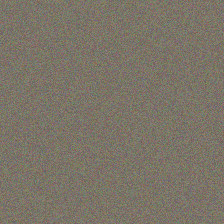

In [11]:
nn.setpic(nn.genpic())
blob2img(nn.autopic.W.data)

Original image set train.jpg
Style image set images/mikakostyle2.jpg
0     0.18005  min-max  -0.0000003700 - 0.0000005008


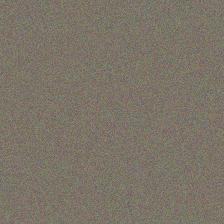

01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950     0.18004  min-max  -0.0000004071 - 0.0000005069


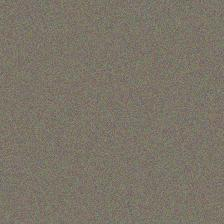

5051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100     0.18002  min-max  -0.0000004062 - 0.0000005233


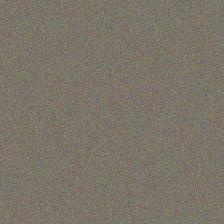

100101102103

KeyboardInterrupt: 

In [12]:
lr = np.float32(1.0) # 学習係数
rr = np.float32(0.3)
generate(nn,"train.jpg","images/mikakostyle2.jpg",itr=1000)

In [13]:
chainer.

TypeError: copyparams() missing 1 required positional argument: 'link'

In [14]:
nn.cleargrads()